In [1]:

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit import Aer, execute
from qiskit.visualization import plot_histogram
from scipy.optimize import minimize,brute
from qutip import Qobj,tensor,sigmax,sigmaz,identity,expect
import timeit

In [2]:
def get_ranges(p,eps):
    l = []
    #the order of the list of parameters is [beta,gamma,alpha]
    #gamma comes from ZZ and goes [0,2pi], the others [0,pi]
    for i in range(3*p):
        if i<p:
            tup = (0.,np.pi,eps)
        elif i>=2*p: 
            tup = (0.,np.pi,eps)
        else:
            tup = (0.,2*np.pi,eps)
        l.append(tup)
    return tuple(l)

COUNT BASED SIMULATOR

ZZ circuit

In [3]:
def create_qaoa_circ_zz(graph, theta):
    """Creates a parametrized qaoa circuit to measure <ZiZj>
       Measures in the computational basis
    Args:
        graph: networkx graph
        theta: (list) [beta,gamma]
    Returns:
        (QuantumCircuit) qiskit circuit
    """
    nqubits = len(graph.nodes())
    n_layers = len(theta)//2  # number of alternating unitaries
    beta = theta[:n_layers]
    gamma = theta[n_layers:]

    qc = QuantumCircuit(nqubits)

    # initial_state
    qc.h(range(nqubits))

    for layer_index in range(n_layers):
        qc.barrier()
        qc.barrier()
        # problem unitary
        for pair in list(graph.edges()):
            qc.rzz(2 * gamma[layer_index], pair[0], pair[1])
        qc.barrier()
        # mixer unitary
        for qubit in range(nqubits):
            qc.rx(2 * beta[layer_index], qubit)
    qc.measure_all()
    return qc


def get_edge_zz_avg(counts,graph):
    """Gives a dictionary of averages of ZiZj
    Args:
        mem_list: list of measurements given by result.get_memory()
        graph: networkx graph for the lattice connectivity
    Returns:
        edges_shot_avg: dict {'(i,j)':<ZiZj>}
    """
    avg = 0
    edges_avg_zz = {str(list(graph.edges)[i]): 0 for i in range(len(list(graph.edges)))}

    for count,n in counts.items():
        count = count[::-1] #invert the string to fix qubit ordering issues
        for i,j in graph.edges:
            avg = (1-2*int(count[i]))*(1-2*int(count[j]))*(n/shots) #converts binary to spin variables, takes product, divides by shots
            edges_avg_zz[str((i,j))]+= avg
    
    return edges_avg_zz

X circuit

In [4]:
def create_qaoa_circ_x(graph, theta):
    """Creates a parametrized qaoa circuit to measure <xi>
       Measures in the x basis, so we add a Hadamard at the end of the circuit
    Args:
        graph: networkx graph
        theta: (list) [beta,gamma]
    Returns:
        (QuantumCircuit) qiskit circuit
    """
    nqubits = len(graph.nodes())
    n_layers = len(theta)//2  # number of alternating unitaries
    beta = theta[:n_layers]
    gamma = theta[n_layers:]

    qc = QuantumCircuit(nqubits)

    # initial_state
    qc.h(range(nqubits))

    for layer_index in range(n_layers):
        qc.barrier()
        qc.barrier()
        # problem unitary
        for pair in list(graph.edges()):
            qc.rzz(2 * gamma[layer_index], pair[0], pair[1])
        qc.barrier()
        # mixer unitary
        for qubit in range(nqubits):
            qc.rx(2 * beta[layer_index], qubit)
    qc.h(range(nqubits)) #Rotation to x-basis
    qc.measure_all()
    return qc

def get_x_avg(counts,graph):
    """Gives a list of averages of Xi for each spin
    Args:
        counts: dict of counts of X given by result_x.get_counts()
        graph: networkx graph for the lattice connectivity
    Returns:
        x_avg: list of averages of X for each spin [Xi]
    """
    avg = 0
    x_avg = [0 for i in graph.nodes]
    
    for count,n in counts.items():
        count = count[::-1] #invert the string to fix qubit ordering issues
        for i in graph.nodes:
            avg = (1-2*int(count[i]))*(n/shots) #converts binary to spin variables, takes product, divides by shots
            x_avg[i]+= avg
    
    return x_avg

Cost function evaluation and passing to optimizer

In [5]:
def compute_TFIM_energy(graph,counts_zz,counts_x,B,J):
    """Computes the energy expectation of the TFIM from the counts in the z- and x-basis
    Args:
        graph: networkx graph
        mem_list_zz: memory list from z measurements
        mem_list_x: memory list from x measurements
        B: Intensity of transverse field
        J: Coupling counstant
    Returns:
        E: Value of the energy expectation value
    """
    sum_zz = sum(get_edge_zz_avg(counts_zz,graph).values())
    sum_x = sum(get_x_avg(counts_x,graph))

    E = -J*sum_zz-B*sum_x #The expression of the TFIM with constant coupling
    return E

def get_expectation(graph, shots=512,B=1.,J=1.):
    """Gives the function to be optimized, includes the 
    quantum routine to run the algortihm
    Args:
        graph: networkx graph
    Returns: function
    """
    backend = Aer.get_backend('aer_simulator')
    backend.shots = shots

    def execute_circ(theta):
        qc_zz = create_qaoa_circ_zz(graph, theta)
        qc_x = create_qaoa_circ_x(graph, theta)
        counts_zz = execute(qc_zz,backend,shots=shots,seed_simulator=10).result().get_counts()
        counts_x = execute(qc_x,backend,shots=shots,seed_simulator=10).result().get_counts()
        
        return compute_TFIM_energy(graph,counts_zz,counts_x,B,J)

    return execute_circ

STATEVECTOR SIMULATOR

In [6]:
def create_qaoa_circ_sv(graph, theta):
    """Creates a parametrized qaoa circuit to measure <ZiZj>
       Does not measure to get the statevector
    Args:
        graph: networkx graph
        theta: (list) unitary parameters
    Returns:
        (QuantumCircuit) qiskit circuit
    """
    nqubits = len(graph.nodes())
    n_layers = len(theta)//2  # number of alternating unitaries
    beta = theta[:n_layers]
    gamma = theta[n_layers:]

    qc = QuantumCircuit(nqubits)

    # initial_state
    qc.h(range(nqubits))

    for layer_index in range(n_layers):
        qc.barrier()
        qc.barrier()
        # problem unitary
        for pair in list(graph.edges()):
            qc.rzz(2 * gamma[layer_index], pair[0], pair[1])
        qc.barrier()
        # mixer unitary
        for qubit in range(nqubits):
            qc.rx(2 * beta[layer_index], qubit)
    #no measurement at the end
    return qc

def compute_TFIM_sv_energy(sv,B,J):
    """Uses qutip to compute the energy expectation
       of the output state in the TFIM
    Args:
        graph: networkx graph
        sv: qiskit statevector at the end of circuit
        B: Intensity of transverse field
        J: Coupling counstant
    Returns:
        E: energy expectation
    """
    n_qubits = int(np.log2(len(sv.data)))
    H = Qobj(get_ising_H(n_qubits=n_qubits,B=B,J=J).full())

    output_sv = get_qutip_sv(sv)
    E = expect(H,output_sv)
    
    return E

def get_expectation_sv(graph,B=1.,J=1.):
    """Gives Function to be optimized in the
    state vector simulator
    Args:
        graph: networkx graph
    Returns: function
    """
    backend = Aer.get_backend('statevector_simulator')

    def execute_circ(theta):
        qc = create_qaoa_circ_sv(graph, theta)
        sv = execute(qc,backend,seed_simulator=10).result().get_statevector()
        return compute_TFIM_sv_energy(sv,B=B,J=J)

    return execute_circ


def compute_TFIM_sv_overlap(sv,B,J):
    """Uses qutip to compute the FIDELITY
       between the output state and the exact
       groundstate 
    Args:
        graph: networkx graph
        sv: qiskit statevector at the end of circuit
        B: Intensity of transverse field
        J: Coupling counstant
    Returns:
        p: Value of the overlap
    """
    n_qubits = int(np.log2(len(sv.data)))
    
    H = Qobj(get_ising_H(n_qubits=n_qubits,B=B,J=J).full())
    exact_sv = Qobj(H.groundstate()[1].full())

    output_sv = get_qutip_sv(sv)


    overlap = output_sv.overlap(exact_sv)
    prob = overlap.real**2+overlap.imag**2
    return prob

QUTIP FUNCTIONS

In [7]:
def get_ising_H(n_qubits,B,J):
    """Gives the TFIM qutip quantum object
    """
    x_i_list = []
    for i in range(n_qubits):
        x_i = []
        for j in range(n_qubits):
            if i==j:
                x_i.append(sigmax())
            else:
                x_i.append(identity(2))

        x_i_list.append(tensor(x_i))
    sum_xi = Qobj()
    for i in range(n_qubits):
        sum_xi += x_i_list[i]
    
    z_i_list = []
    for i in range(n_qubits):
        z_i = [identity(2) for i in range(n_qubits)]
        for j in range(n_qubits):
            if j == i:
                z_i[j] = sigmaz()
                if j < n_qubits-1:
                    z_i[j+1] = sigmaz()
                else:
                    z_i[0]=sigmaz()
        z_i_list.append(tensor(z_i))
    sum_zi = Qobj()
    for i in range(n_qubits):
        sum_zi += z_i_list[i]   

    Hb = -B*sum_xi
    Hc = -J*sum_zi
    H = Hb + Hc
    return H

def get_qutip_sv(sv,eps=1e-15):
    """Translates the statevector from qiskit to qutip
    Args:
        sv: qiskit statevector object
        eps: precision to filter the amplitudes
    Returns:
        svqtp: associated qutip object with filtered amplitudes
    """
    eps = 1e-15
    l = list(sv.data)[:]
    for i,amp in enumerate(list(sv.data)):
        if abs(amp.real) < eps:
            l[i] = 0 + amp.imag*1j
        if abs(amp.imag) < eps:
            l[i] = amp.real + 0j
    
    return Qobj(np.array(l))

We entry the shape of the lattice as a networkx graph

In [8]:
# Sample initial graphs

g1 = nx.Graph()
g1.add_edges_from([[0,3],[0,4],[1,3],[1,4],[2,3],[2,4]])

g2 = nx.Graph()
g2.add_nodes_from([0, 1, 2, 3])
g2.add_edges_from([(0, 1), (1, 2), (2, 3), (3, 0)])

graph_bt_3= nx.Graph()


In [9]:
graph_bt_3 = nx.Graph()
graph_bt_3.add_nodes_from([0, 1, 2])
graph_bt_3.add_edges_from([(0, 1), (0, 2)])

graph_bt_7 = nx.Graph()
graph_bt_7.add_nodes_from([0, 1, 2, 3, 4, 5, 6])
graph_bt_7.add_edges_from([(0, 1), (0, 2),(1,3),(1,4),(2,5),(2,6)])

graph_bt_15 = nx.Graph()
graph_bt_15.add_nodes_from(range(2**3-1))
graph_bt_15.add_edges_from([(0, 1), (0, 2),(1,3),(1,4),(2,5),(2,6),(3,7),(3,8),(4,9),(4,10),(5,11),(5,12),(6,13),(6,14)])
graph_bt_list = [graph_bt_3,graph_bt_7,graph_bt_15]

GLOBAL PARAMETERS

In [10]:

n_qubits = 3
B = 0.5
J = 1.
shots = 2**14

In [11]:
graph_chain = nx.Graph()
graph_chain.add_nodes_from(range(n_qubits))

edge_list = []
for i in range(n_qubits):
    if i < n_qubits-1:
        edge_list.append((i,i+1))
    else:
        edge_list.append((i,0))

# Generate graph from the list of edges
graph_chain.add_edges_from(edge_list)

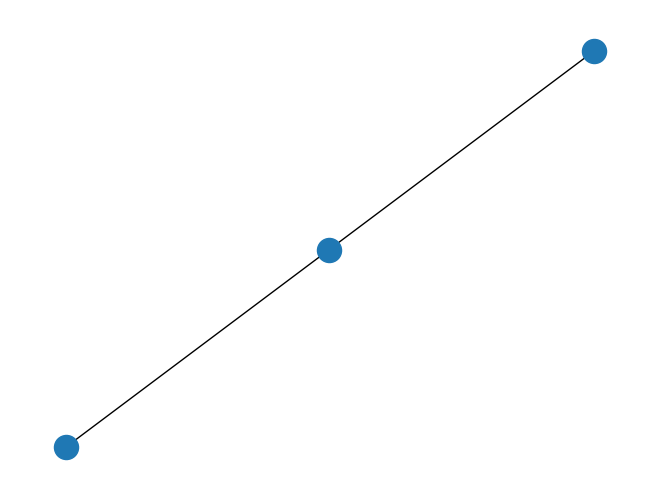

In [12]:
graph = graph_bt_3
nx.draw(graph)

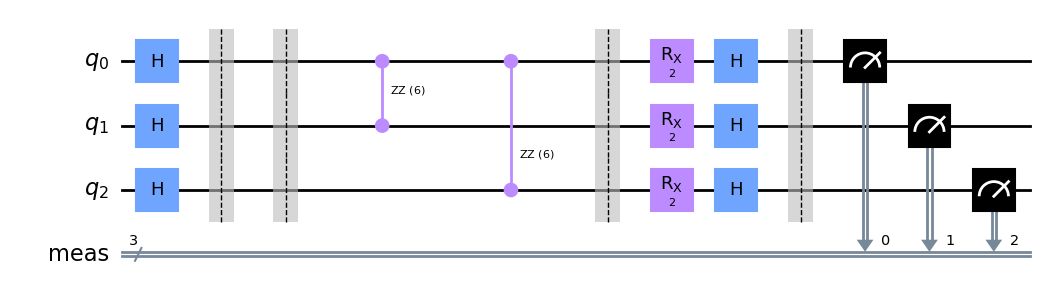

In [13]:
qc = create_qaoa_circ_x(graph,[1,3])
qc.draw('mpl')

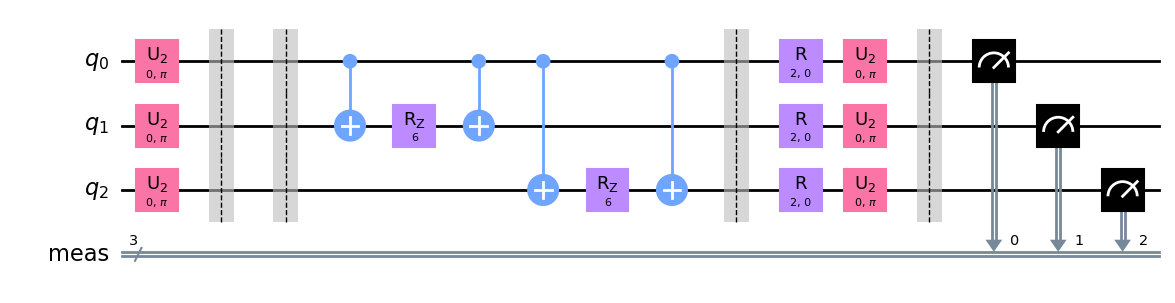

In [14]:
qc.decompose(reps=1).draw('mpl')

We display the form of the circuit for one layer (p=1)

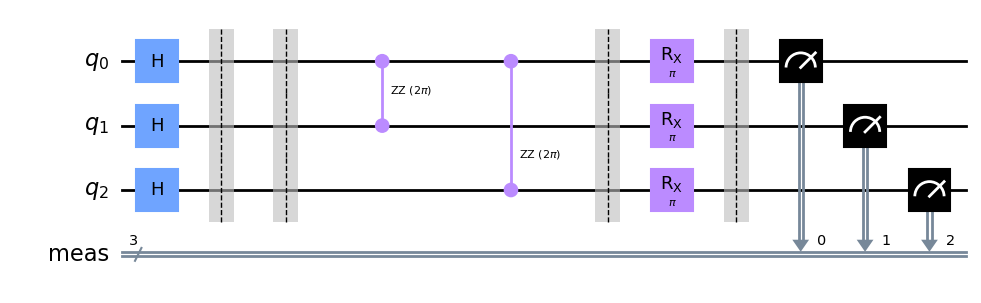

In [15]:
qc = create_qaoa_circ_zz(graph,[np.pi/2,np.pi])
display(qc.draw('mpl')) 

We also show the associated circuit to measure in the X basis, which has a layer of Hadamard gates at the end to change basis 

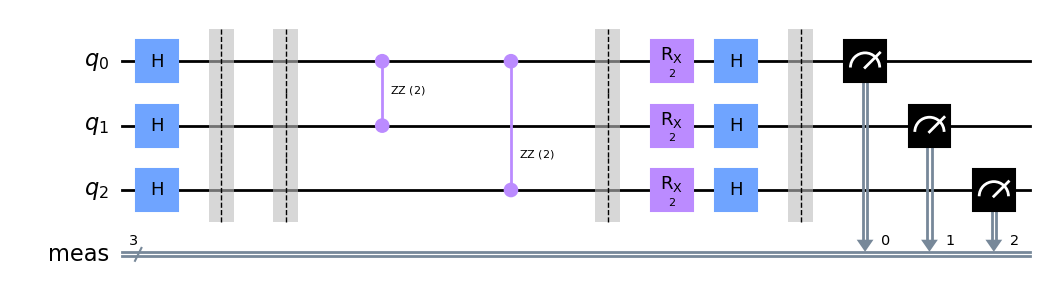

In [16]:
qc_x = create_qaoa_circ_x(graph,[1,1])
display(qc_x.draw('mpl')) 

Now we perform the feedback loop to obtain the optimal parameters

The exact groundstate energy for this spin configuration is

In [17]:
# exact_gs = get_ising_H(n_qubits=n_qubits,B=B,J=J).groundstate()[0]
# exact_gs

In [18]:
hz = -1*(tensor(sigmaz(),sigmaz(),identity(2))+
         tensor(sigmaz(),identity(2),sigmaz())
         )
hx = -0.5*(tensor(sigmax(),identity(2),identity(2))+
         tensor(identity(2),sigmax(),identity(2))+
         tensor(identity(2),identity(2),sigmax()))

exact_gs = (hz+hx).groundstate()[0]
exact_gs

-2.403211925911554

ONE LAYER

In [19]:
p = 1 # Number of layers

iter = 2500 #Number of iterations of the optimizer (calls to the Quantum Computer)
optimizer = 'COBYLA'

one_list = [1 for i in range(0,2*p)] 

parameter_list = one_list #We start setting all parameters to unity

expectation_1 = get_expectation(graph,shots=shots,B=B,J=J) #Cost function C(teta) of the entire circuit (training)

res_1 = minimize(expectation_1,
               parameter_list,
               method=optimizer,options={'maxiter':iter, 'disp': True})
res_1


   Normal return from subroutine COBYLA



     fun: -2.1947021484375
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 35
  status: 1
 success: True
       x: array([1.95760899, 0.34668351])

   NFVALS =   35   F =-2.194702E+00    MAXCV = 0.000000E+00
   X = 1.957609E+00   3.466835E-01


BRUTE FORCE ONE LAYER

In [20]:
res_1_b = brute(expectation_1,((0,np.pi,np.pi/6),(0,2*np.pi,np.pi/6)))
print(res_1_b)

aprox_gs = expectation_1(res_1_b)
aprox_ratio = aprox_gs/exact_gs
print(aprox_ratio)
# np.savetxt('1-layer-4qubits-parameters.csv',res_1_b,delimiter=",")

[0.39893727 0.31748289]
0.9139481662564516


In [21]:
expectation_1(res_1_b)/exact_gs

0.9139481662564516

APROXIMATION RATIO (p = 1)

In [22]:
aprox_gs = res_1.fun

aprox_ratio = aprox_gs/exact_gs
aprox_ratio

0.9132370411340378

We already get a good precision at one layer

TWO LAYERS (p = 2)

In [23]:
p = 2 # Number of layers

iter = 86 #Number of iterations of the optimizer (calls to the Quantum Computer)
optimizer = 'COBYLA'

one_list = [1 for i in range(0,2*p)] 

parameter_list = one_list #We start setting all parameters to unity

expectation = get_expectation(graph,shots=shots,B=B,J=J) #Cost function C(teta) of the entire circuit (training)

res_2 = minimize(expectation,
               parameter_list,
               method=optimizer,options={'maxiter':iter, 'disp': True})
res_2

     fun: -2.3431396484375
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 57
  status: 1
 success: True
       x: array([1.90761294, 1.07877192, 2.0256771 , 0.84816215])


   Normal return from subroutine COBYLA

   NFVALS =   57   F =-2.343140E+00    MAXCV = 0.000000E+00
   X = 1.907613E+00   1.078772E+00   2.025677E+00   8.481621E-01


APROX RATIO (p = 2)

In [24]:
aprox_gs = res_2.fun

aprox_ratio = aprox_gs/exact_gs
aprox_ratio

0.9750033374808308

BRUTE FORCE 2 LAYERS 

THREE LAYERS (p = 3)

In [25]:
p = 3 # Number of layers

iter = 150 #Number of iterations of the optimizer (calls to the Quantum Computer)
optimizer = 'COBYLA'

one_list = [1 for i in range(0,2*p)] 

parameter_list = one_list #We start setting all parameters to unity

expectation = get_expectation(graph,shots=shots,B=B,J=J) #Cost function C(teta) of the entire circuit (training)

res_3 = minimize(expectation,
               parameter_list,
               method=optimizer,options={'maxiter':iter, 'disp': True})
res_3


   Normal return from subroutine COBYLA



     fun: -2.4027099609375
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 77
  status: 1
 success: True
       x: array([0.73680106, 1.99340296, 1.92051285, 1.03231738, 0.70311513,
       1.51306043])

   NFVALS =   77   F =-2.402710E+00    MAXCV = 0.000000E+00
   X = 7.368011E-01   1.993403E+00   1.920513E+00   1.032317E+00   7.031151E-01
       1.513060E+00


APROX RATIO

In [26]:
aprox_gs = res_3.fun

aprox_ratio = aprox_gs/exact_gs
aprox_ratio

0.9997911274621095

We can also try the Statevector approach to get a better precision

ONE LAYER STATEVECTOR

In [27]:
p = 1 # Number of layers

iter = 2500 #Number of iterations of the optimizer (calls to the Quantum Computer)
optimizer = 'COBYLA'

one_list = [1 for i in range(0,2*p)]
parameter_list = one_list #We start setting all parameters to unity

expectation = get_expectation_sv(graph,B=B,J=J) #Cost function C(teta) of the entire circuit (training)
res_sv_1 = minimize(expectation,
               parameter_list,
               method='COBYLA',options={'maxiter':iter, 'disp': True})
res_sv_1


   Normal return from subroutine COBYLA



     fun: -2.440982734559044
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 38
  status: 1
 success: True
       x: array([3.58718614, 0.40595638])

   NFVALS =   38   F =-2.440983E+00    MAXCV = 0.000000E+00
   X = 3.587186E+00   4.059564E-01


In [28]:
res_sv_1.fun

-2.440982734559044

APROX RATIO (p=1)

In [29]:
aprox_gs_sv = res_sv_1.fun

aprox_ratio_sv = aprox_gs_sv/exact_gs
aprox_ratio_sv 

1.0157168031001524

TWO LAYERS STATEVECTOR

In [30]:
p = 2 # Number of layers

iter = 2500 #Number of iterations of the optimizer (calls to the Quantum Computer)
optimizer = 'COBYLA'

one_list = [1 for i in range(0,2*p)]
parameter_list = one_list #We start setting all parameters to unity

expectation = get_expectation_sv(graph,B=B,J=J) #Cost function C(teta) of the entire circuit (training)
res_sv_2 = minimize(expectation,
               parameter_list,
               method='COBYLA',options={'maxiter':iter, 'disp': True})
res_sv_2


   Normal return from subroutine COBYLA

   NFVALS =  259   F =-2.823844E+00    MAXCV = 0.000000E+00
   X = 1.862965E+00   1.032591E+00   2.176893E+00   6.415381E-01


     fun: -2.823843771818605
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 259
  status: 1
 success: True
       x: array([1.86296505, 1.03259106, 2.17689294, 0.64153812])

APROX RATIO (p = 2)

In [31]:
aprox_gs_sv = res_sv_2.fun

aprox_ratio_sv = aprox_gs_sv/exact_gs
aprox_ratio_sv 

1.1750290273495139

Now we run the circuit with the optimal parameters to measure the fidelity

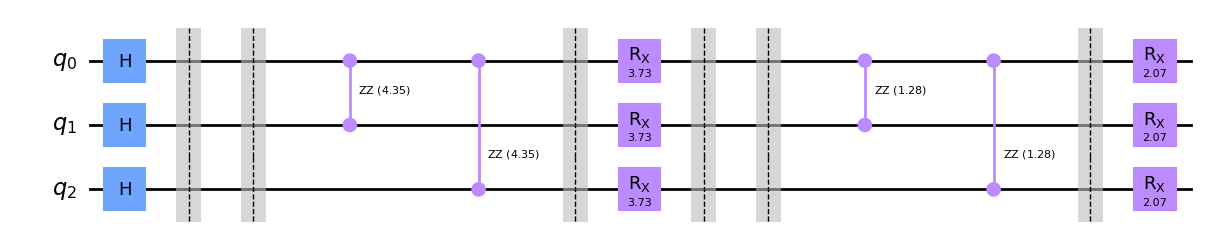

In [32]:
backend = Aer.get_backend('statevector_simulator')
#optimal_parameters = [0.6845, 0.6559,0.6048,0.3180,0.2496,0.4808,0.5260,0.4503]
optimal_parameters =res_sv_2.x
optimal_circuit = create_qaoa_circ_sv(graph,optimal_parameters)
display(optimal_circuit.draw('mpl'))


optimal_sv = execute(optimal_circuit,backend).result().get_statevector()


The fidelity with the exact groundstate is 

In [33]:
fidelity = compute_TFIM_sv_overlap(optimal_sv,B=B,J=J)
fidelity


0.905643408215995

We can use the optimal circuit to compute the energy from the counts. Useful for quantum hardware

In [34]:
backend = Aer.get_backend('aer_simulator')

optimal_circuit_zz = create_qaoa_circ_zz(graph,optimal_parameters)
optimal_counts_zz = execute(optimal_circuit_zz,backend,seed_simulator=10,shots=shots).result().get_counts()
optimal_circuit_x = create_qaoa_circ_x(graph,optimal_parameters)
optimal_counts_x = execute(optimal_circuit_x,backend,memory=True,seed_simulator=10,shots=shots).result().get_counts()

print(compute_TFIM_energy(graph,optimal_counts_zz,optimal_counts_x,B=B,J=J))


-2.2965087890625
